# Prepare the environment

Install python libraries:

In [1]:
#!pip install scanpy[leiden] scrublet bbknn harmonypy scanorama

Import libraries

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scanpy.external as sce
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad

import bbknn
import scanorama


# Function to calculate fraction of each batch in a cluster
def plot_batch_fr(adata):
    batch_sum = adata.obs[['leiden', 'batch']]\
        .groupby(['leiden', 'batch'], as_index=False)\
        .value_counts()\
        .pivot(index='leiden', columns='batch', values='count')
    batch_frac = batch_sum.div(batch_sum.sum(axis=1), axis=0)

    batch_frac.plot.bar(stacked=True, figsize=[6, 3])
    return


def subsetHVgenes(adata):
    return  adata[:, adata.var["highly_variable"]]

def save_raw_and_norm(adata):
    # Save raw counts to a layer
    adata.layers['counts'] = adata.X.copy()
    # Normalize each cell by total counts over all genes; then logarithmize
    sc.pp.normalize_total(adata); sc.pp.log1p(adata)
    adata.layers["norm"] = adata.X.copy()
    adata.X = adata.layers['counts'].copy()
    return adata

def do_residuals(adata, hv_subset = False, batch_key =None ):
    # uses raw data, indicate the "n_top_genes" genes that have the most variable Pearson residuals.
    sc.experimental.pp.highly_variable_genes( adata, batch_key = batch_key, flavor="pearson_residuals", n_top_genes=3000)
    if hv_subset: adata = subsetHVgenes(adata)
    adata = save_raw_and_norm(adata)
    # uses raw data, to compute pearson residuals and place dte data to X
    sc.experimental.pp.normalize_pearson_residuals(adata)
    adata.layers['residuals'] = adata.X.copy()
    return adata

def do_z_score(adata, hv_subset = False, batch_key =None ):
    adata = save_raw_and_norm(adata)
    adata.X = adata.layers["norm"].copy()

    sc.pp.highly_variable_genes(adata, batch_key = batch_key)
    if hv_subset: adata = subsetHVgenes(adata)
    sc.pp.scale(adata) 
    return adata


def process_data(adata, pearson_residuals = True, batch_key =None , hv_subset = False):
    if pearson_residuals :
        return do_residuals(adata, hv_subset, batch_key =batch_key )
    else :
        return do_z_score(adata, hv_subset, batch_key =batch_key)

def do_pca(adata, pearson_residuals = True,  plot=True, n_comps=50):
    if pearson_residuals:
        # Copy Pearson residuals to adata.X
        adata.X = adata.layers['residuals'].copy()
    
    # Plot PCA on highly variable genes    
    sc.tl.pca(adata, mask_var="highly_variable",n_comps = n_comps)

    # Plot PCA
    if plot:
        sc.pl.pca_variance_ratio(adata, n_pcs=n_comps)
    
    return adata



Set some parameters for `scanpy`:

In [3]:
sc.settings.verbosity = 0             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=100, facecolor='white')

scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


# Read data

In [4]:
adata_b1 = sc.read_10x_mtx(
    'bob_1/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',       # use gene symbols for the variable names (variables-axis index)
    cache=True)

adata_b1.var_names_make_unique()
adata_b1


adata_b2 = sc.read_10x_mtx(
    'bob_2/filtered_feature_bc_matrix/',  # the directory with the `.mtx` file
    var_names='gene_symbols',       # use gene symbols for the variable names (variables-axis index)
    cache=True)

adata_b2.var_names_make_unique()
adata_b2

# Subsample batches to 5k cells each
# so that Colab doesn't crash
sc.pp.subsample(adata_b1, n_obs=5000, random_state=0)
sc.pp.subsample(adata_b2, n_obs=5000, random_state=0)
adata_b1

AnnData object with n_obs × n_vars = 5000 × 21639
    var: 'gene_ids', 'feature_types'

# QC and filtering

In [5]:
def plot_mt(adata):
    fig, ax = plt.subplots(1, 2, figsize=[8, 4])
    sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', show=False, ax=ax[0])
    ax[0].set_xlabel("Total counts")
    ax[0].set_ylabel("% of mitochondrial counts")
    sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax=ax[1])
    plt.tight_layout()
    plt.show()
    
def filter_adata_preprocess(adata):
    # Filter cells and genes with low counts
    sc.pp.filter_cells(adata, min_genes=500)
    sc.pp.filter_genes(adata, min_cells=3)

    # Filter cells with high fraction of mitochondrial genes
    adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    plot_mt(adata)

    return adata

def filter_adata(adata, n_genes_by_counts_, pct_counts_mt_):
    adata = adata[adata.obs.n_genes_by_counts < n_genes_by_counts_, :]
    adata = adata[adata.obs.pct_counts_mt < pct_counts_mt_, :]

    # Remove doublets
    sc.pp.scrublet(adata)
    adata = adata[~adata.obs['predicted_doublet'], :]

    return adata

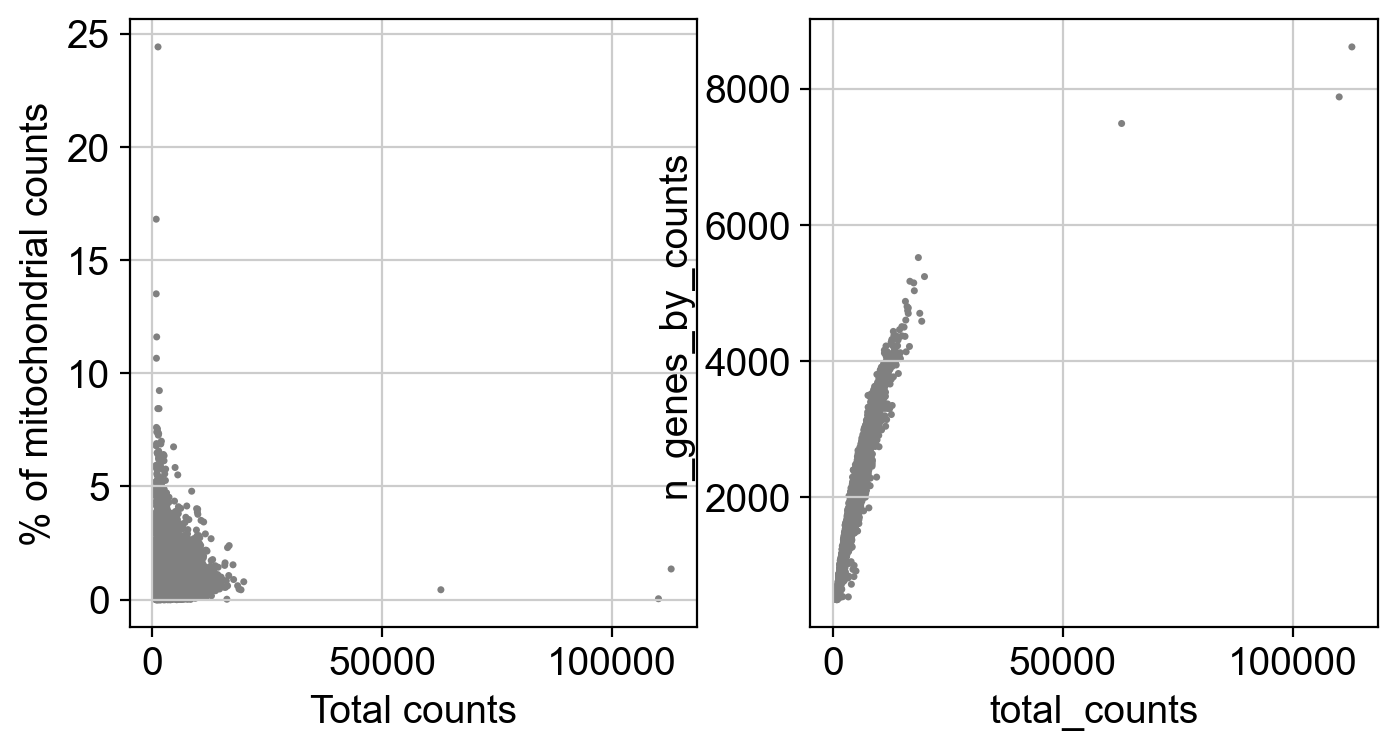

<Figure size 400x400 with 0 Axes>

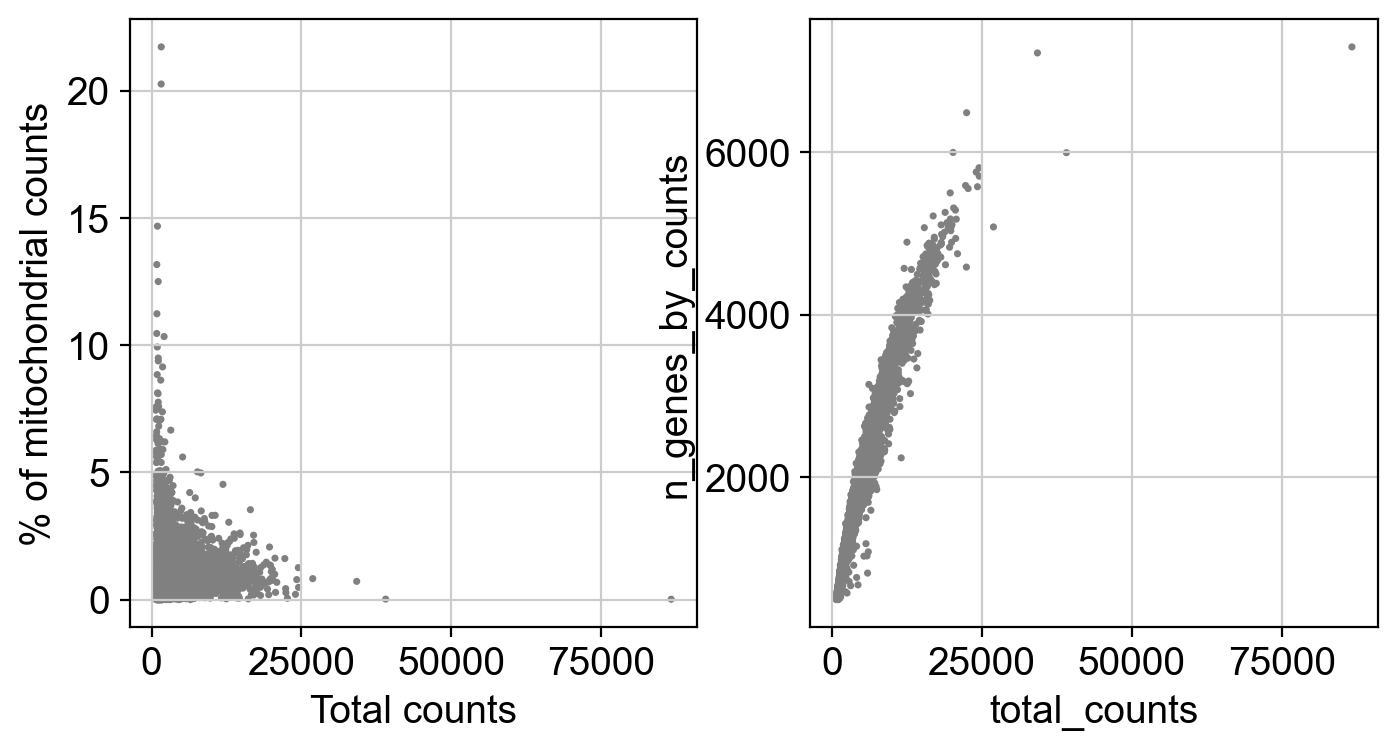

<Figure size 400x400 with 0 Axes>

In [6]:
adata_b1 = filter_adata_preprocess(adata_b1)
adata_b2 = filter_adata_preprocess(adata_b2)

In [7]:
adata_b1 = filter_adata(adata_b1, 6000, 10)
adata_b2 = filter_adata(adata_b2, 6000, 10)

c:\Users\svk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_scrublet\__init__.py:286: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = scrubbed["obs"]["doublet_score"]
c:\Users\svk\AppData\Local\Programs\Python\Python310\lib\site-packages\scanpy\preprocessing\_scrublet\__init__.py:286: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["doublet_score"] = scrubbed["obs"]["doublet_score"]


In [8]:
# Concatenate two batches into single AnnData object
adata = ad.concat([adata_b1, adata_b2], join='inner', label='batch')
adata.obs_names_make_unique()
adata

c:\Users\svk\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 9199 × 15765
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'batch'

# Batch-balanced kNN (Pearson residuals)

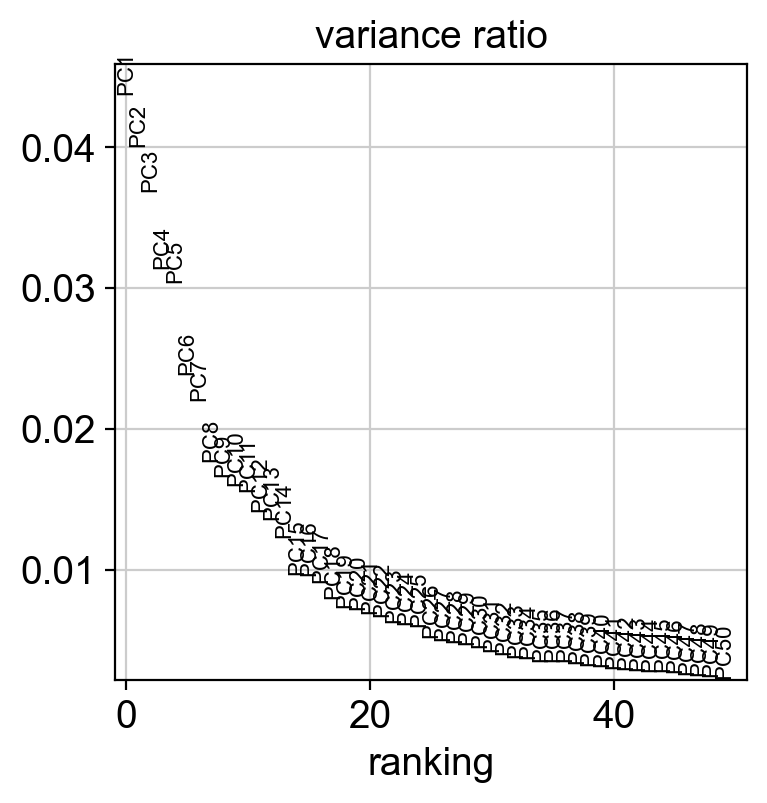

C:\Users\svk\AppData\Local\Temp\ipykernel_14112\990647977.py:10: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_bbknn)


In [9]:
adata_bbknn = adata.copy()

pr = True
adata_bbknn = process_data(adata_bbknn, pearson_residuals = pr, batch_key='batch', hv_subset = False)
adata_bbknn = do_pca(adata_bbknn, pearson_residuals = pr, n_comps =50)

# Calculate kNN graph
bbknn.bbknn(adata_bbknn, batch_key='batch', n_pcs=40)
# Calculate leiden clusters
sc.tl.leiden(adata_bbknn)
# Calculate UMAP
sc.tl.umap(adata_bbknn)

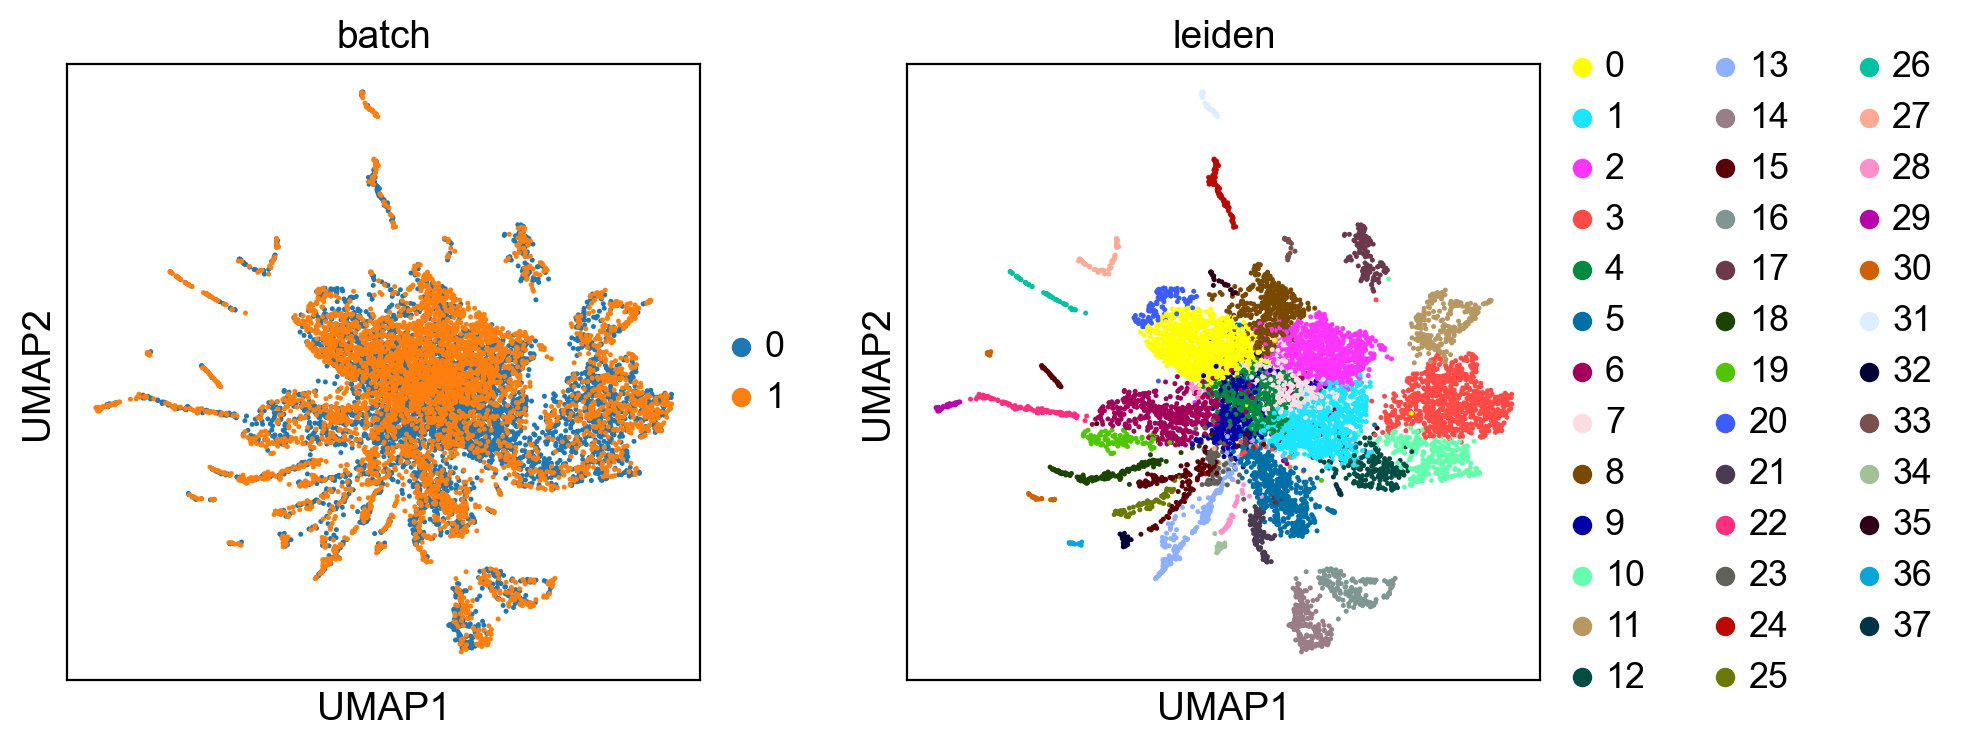

C:\Users\svk\AppData\Local\Temp\ipykernel_14112\4246019723.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_sum = adata.obs[['leiden', 'batch']]\


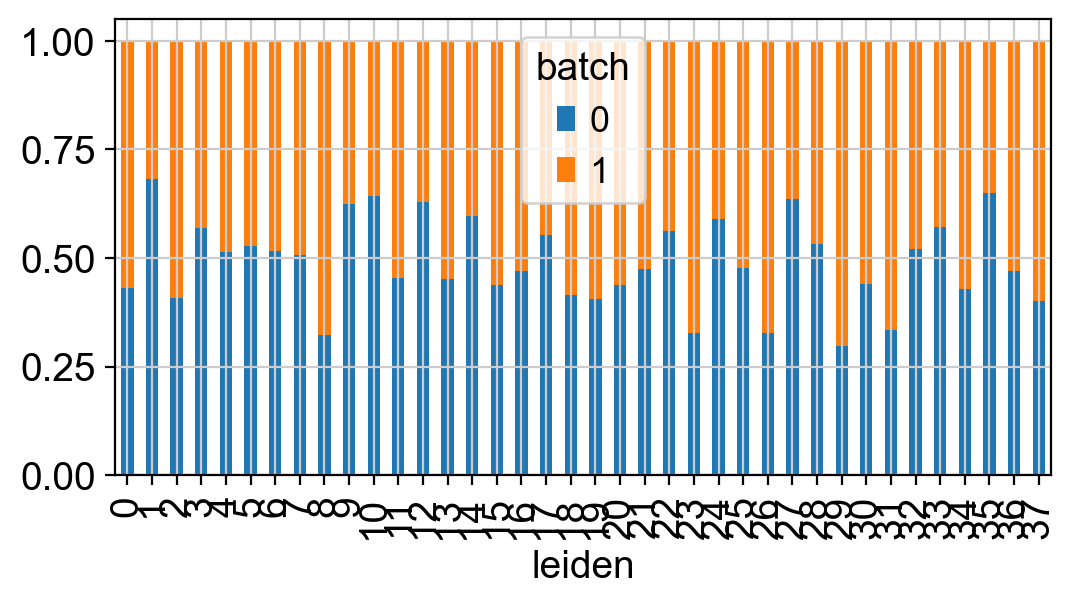

In [10]:
sc.pl.umap(adata_bbknn, color=['batch', 'leiden'])
plot_batch_fr(adata_bbknn)
del adata_bbknn

# Batch-balanced kNN (Z-score)

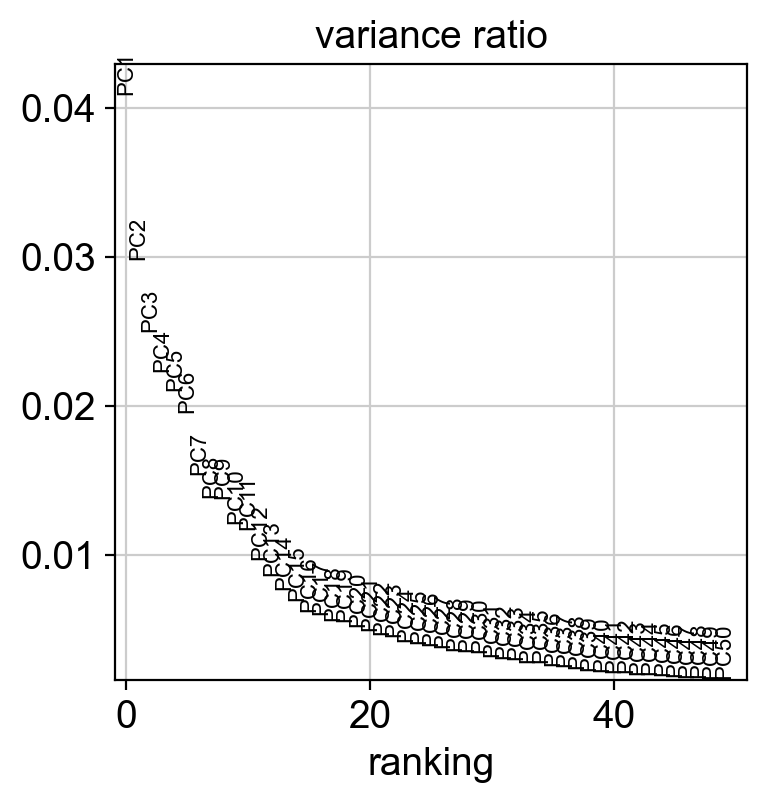

In [34]:
adata_bbknn = adata.copy()

pr = False
adata_bbknn = process_data(adata_bbknn, pearson_residuals = pr, batch_key='batch', hv_subset = False)
adata_bbknn = do_pca(adata_bbknn, pearson_residuals = pr, n_comps =50)

# Calculate kNN graph
bbknn.bbknn(adata_bbknn, batch_key='batch', n_pcs=40)
# Calculate leiden clusters
sc.tl.leiden(adata_bbknn)
# Calculate UMAP
sc.tl.umap(adata_bbknn)

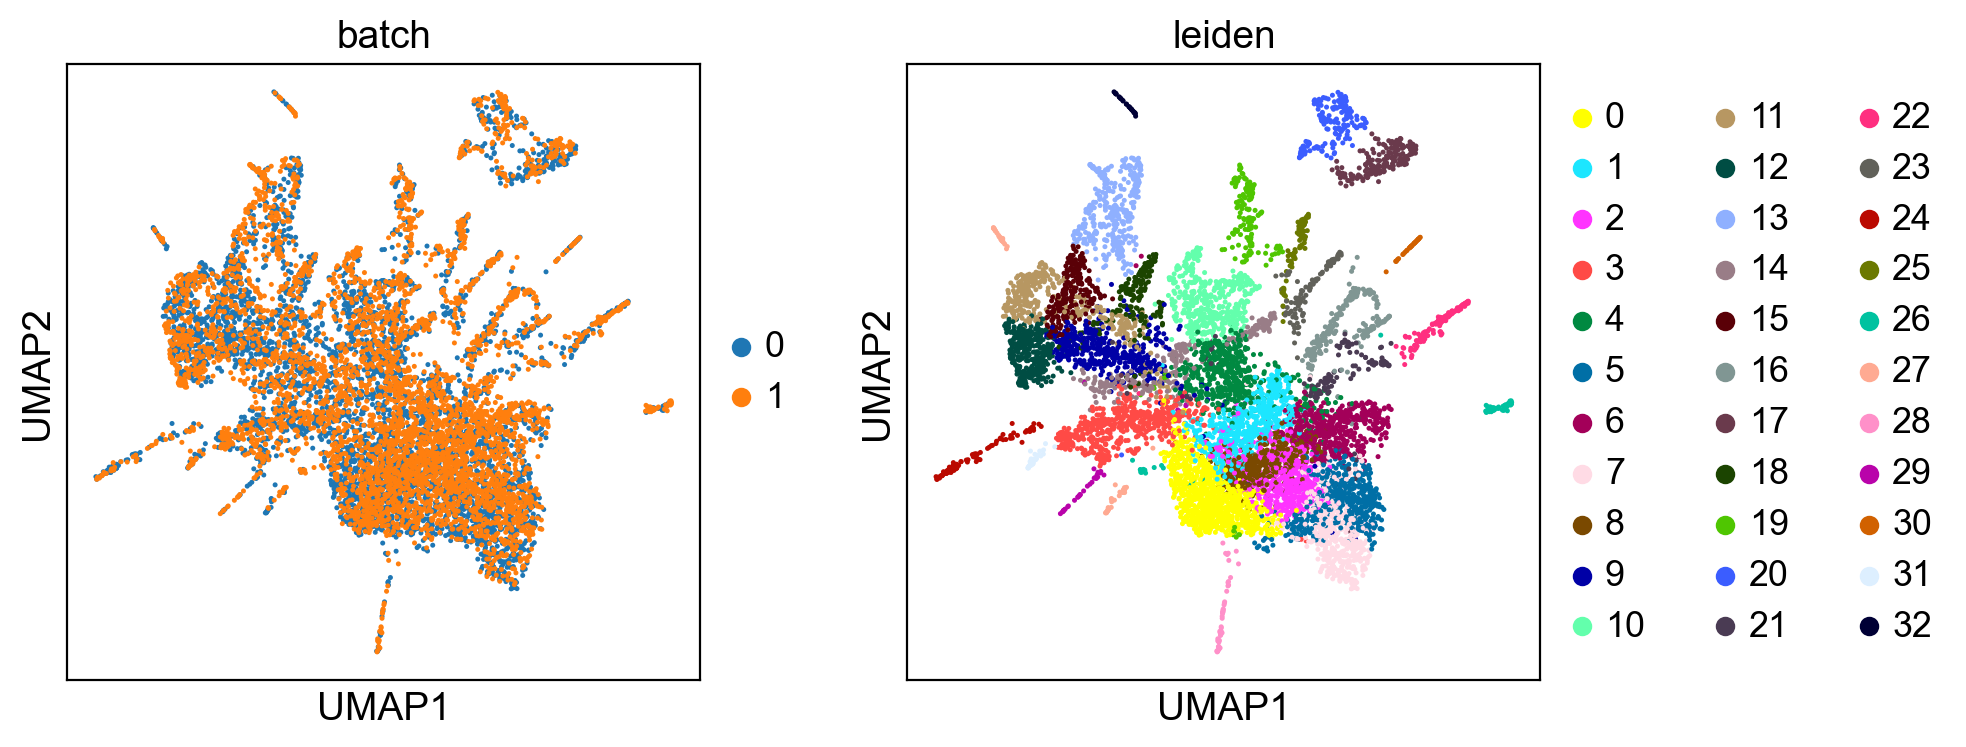

C:\Users\svk\AppData\Local\Temp\ipykernel_14112\4246019723.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_sum = adata.obs[['leiden', 'batch']]\


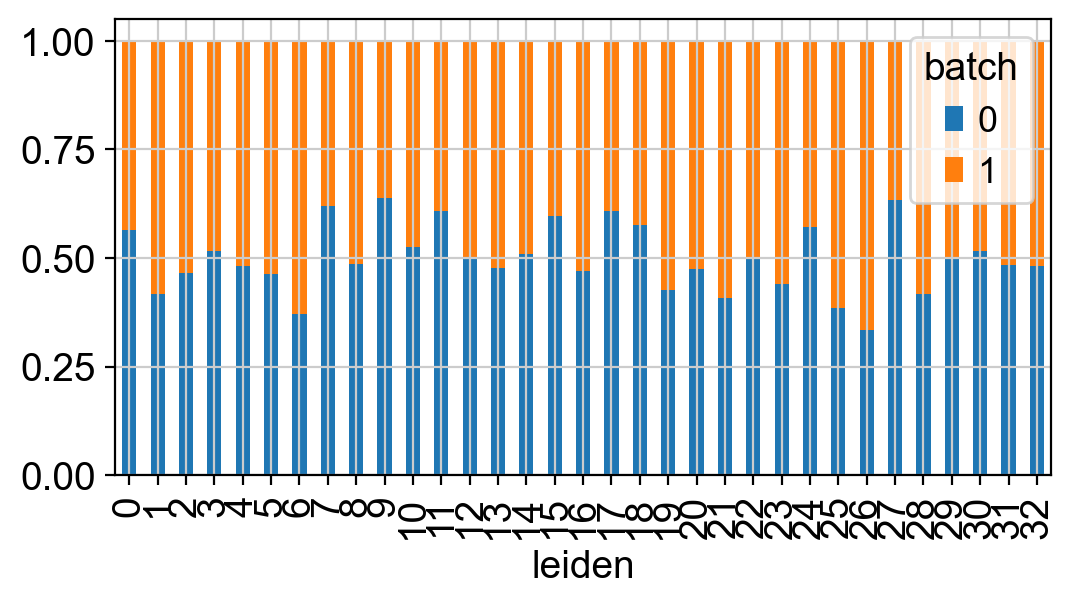

In [35]:
sc.pl.umap(adata_bbknn, color=['batch', 'leiden'])
plot_batch_fr(adata_bbknn)
del adata_bbknn

# Scanorama (Z-score)

In [17]:
adatas_scan = [adata_b1.copy(), adata_b2.copy()]
# Calculate highly variable genes FOR EACH BATCH SEPARATELY
pr = False
for i in range(len(adatas_scan)):
    adatas_scan[i] = process_data(adatas_scan[i], pearson_residuals = pr,  hv_subset = False)

In [19]:
scanorama.integrate_scanpy(adatas_scan)

Found 15765 genes among all datasets
[[0.         0.90535161]
 [0.         0.        ]]
Processing datasets (0, 1)


In [21]:
# Concatenate two batches into single AnnData object
adata_scan = ad.concat(adatas_scan, join='inner', label='batch')
adata_scan.obs_names_make_unique()
adata_scan

c:\Users\svk\AppData\Local\Programs\Python\Python310\lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 9199 × 15765
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'batch'
    obsm: 'X_scanorama'
    layers: 'counts', 'norm'

In [22]:
# Calculate kNN graph
sc.pp.neighbors(adata_scan, n_pcs=40, use_rep='X_scanorama')
# Calculate leiden clusters
sc.tl.leiden(adata_scan)
# Calculate UMAP
sc.tl.umap(adata_scan)

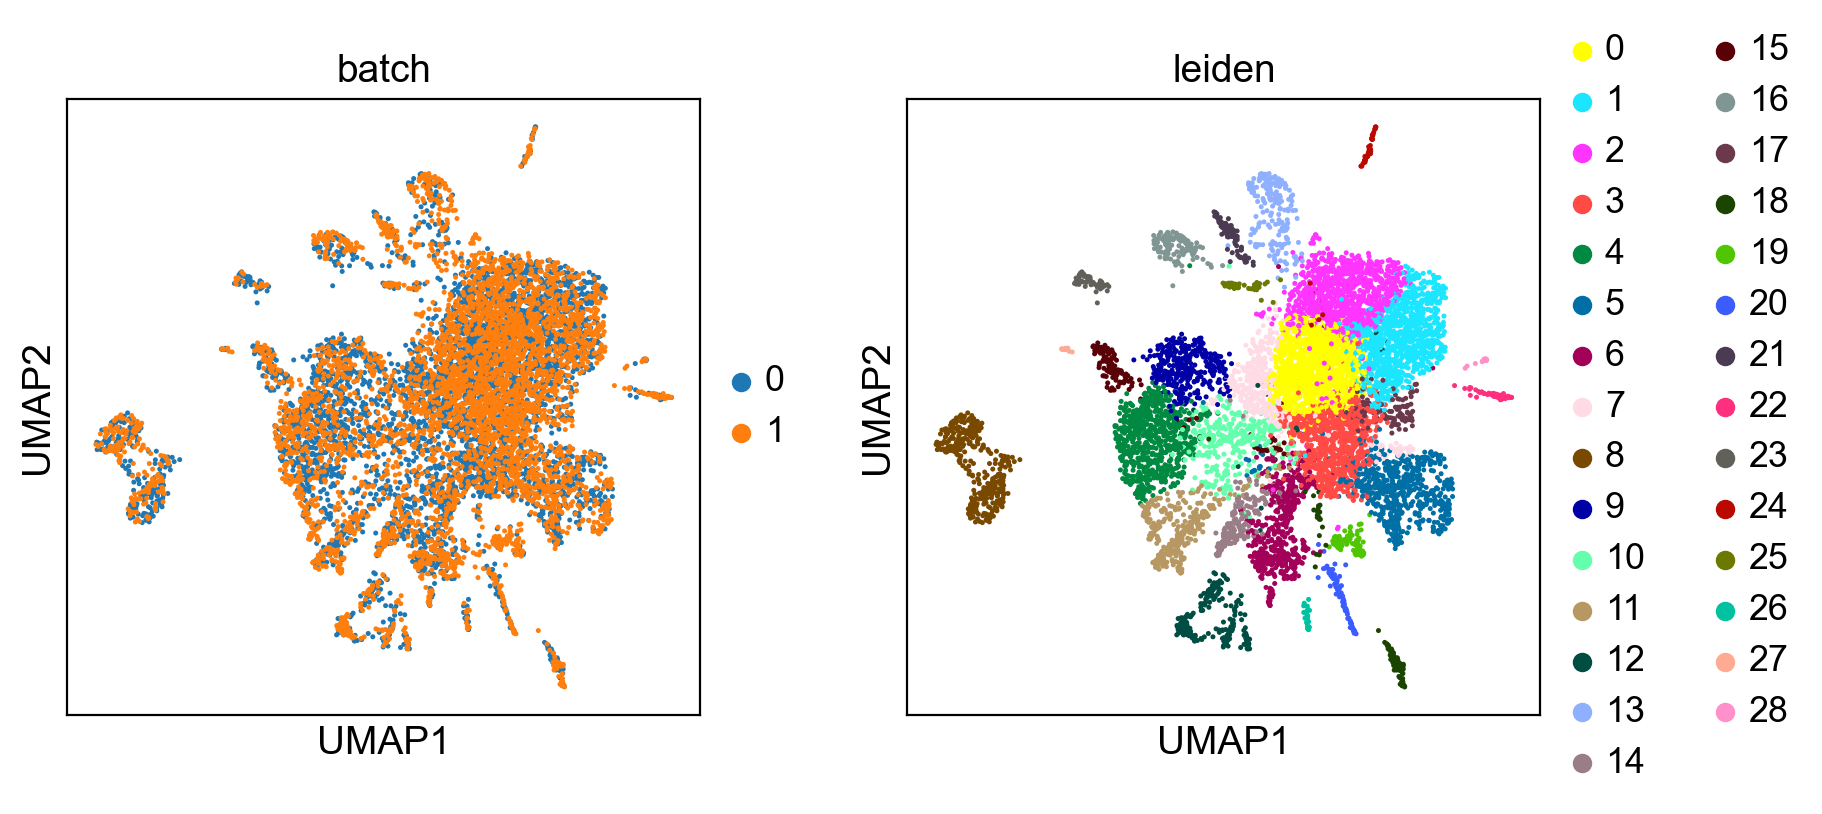

C:\Users\svk\AppData\Local\Temp\ipykernel_14112\4246019723.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_sum = adata.obs[['leiden', 'batch']]\


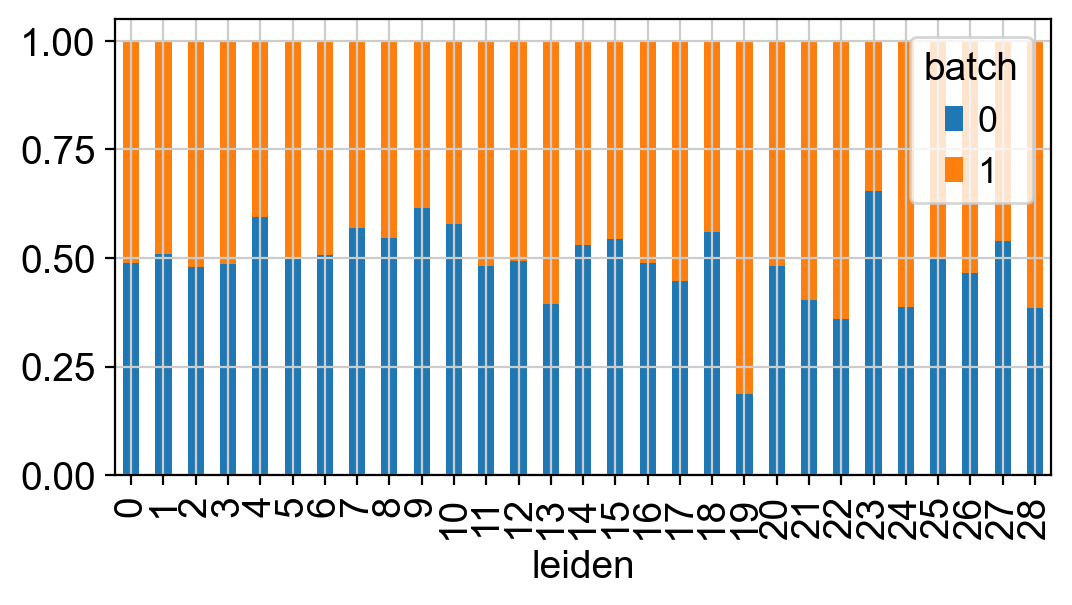

In [23]:
sc.pl.umap(adata_scan, color=['batch', 'leiden'])
plot_batch_fr(adata_scan)
del adata_scan

# Harmony pearson residuals

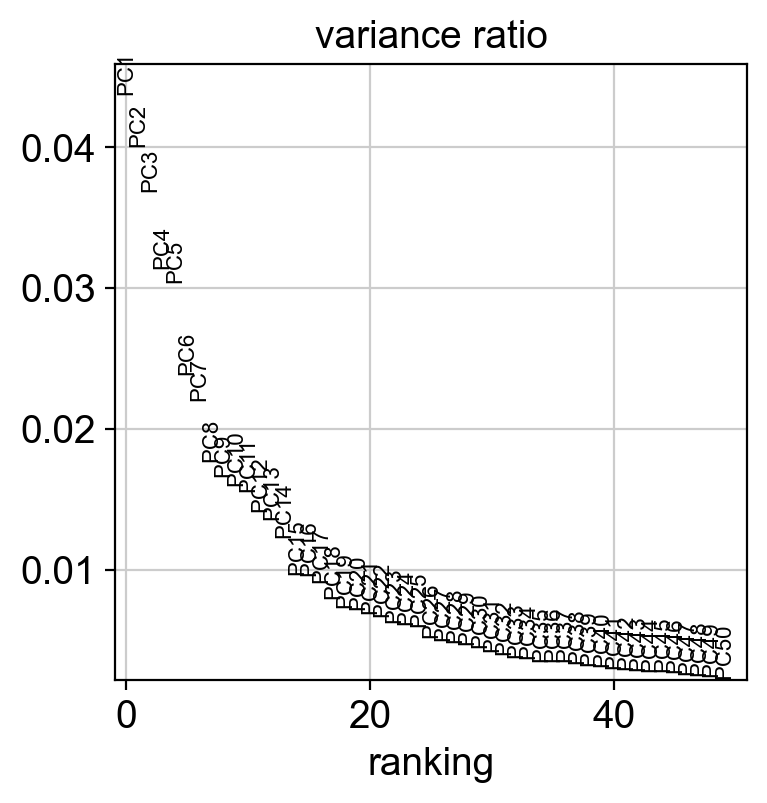

In [25]:
adata_har = adata.copy()
pr = True
adata_har = process_data(adata_har, pearson_residuals = pr, batch_key='batch', hv_subset = False)
adata_har = do_pca(adata_har, pearson_residuals = pr, n_comps =50)

In [26]:
# Run Harmony to correct PCA
sc.external.pp.harmony_integrate(adata_har, key='batch', max_iter_harmony=20)

# Calculate kNN graph
sc.pp.neighbors(adata_har, n_pcs=40, use_rep='X_pca_harmony')
# Calculate leiden clusters
sc.tl.leiden(adata_har)
# Calculate UMAP
sc.tl.umap(adata_har)

2024-05-13 21:31:43,417 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-13 21:31:45,143 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-13 21:31:45,192 - harmonypy - INFO - Iteration 1 of 20
2024-05-13 21:31:47,491 - harmonypy - INFO - Iteration 2 of 20
2024-05-13 21:31:49,585 - harmonypy - INFO - Iteration 3 of 20
2024-05-13 21:31:52,072 - harmonypy - INFO - Iteration 4 of 20
2024-05-13 21:31:54,405 - harmonypy - INFO - Iteration 5 of 20
2024-05-13 21:31:55,678 - harmonypy - INFO - Iteration 6 of 20
2024-05-13 21:31:56,723 - harmonypy - INFO - Iteration 7 of 20
2024-05-13 21:31:57,762 - harmonypy - INFO - Converged after 7 iterations


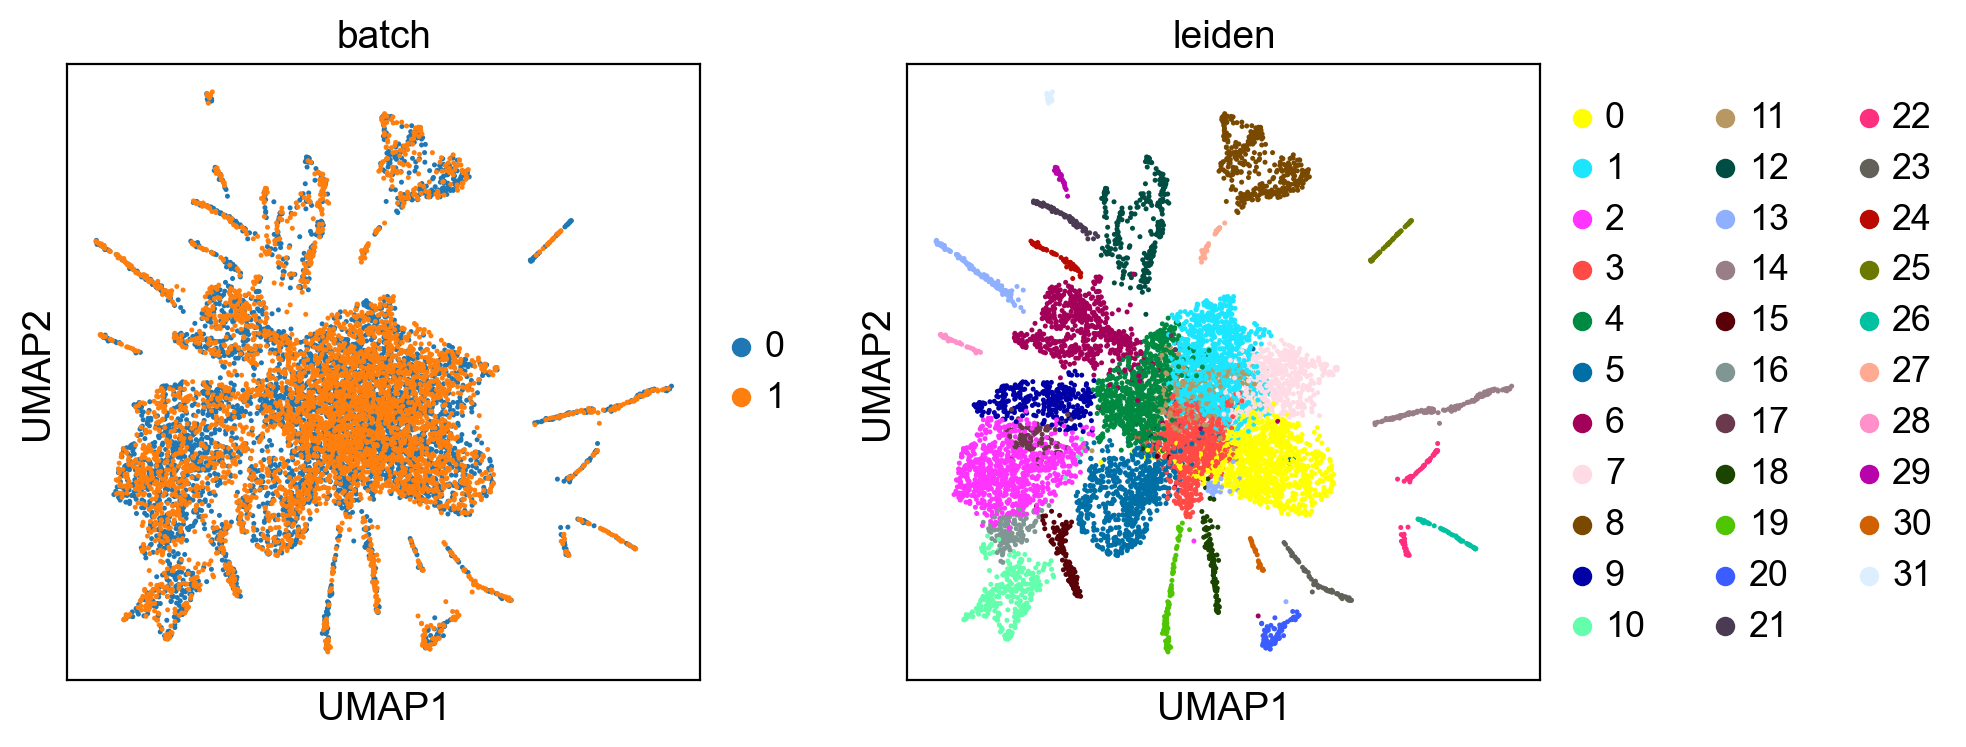

C:\Users\svk\AppData\Local\Temp\ipykernel_14112\4246019723.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_sum = adata.obs[['leiden', 'batch']]\


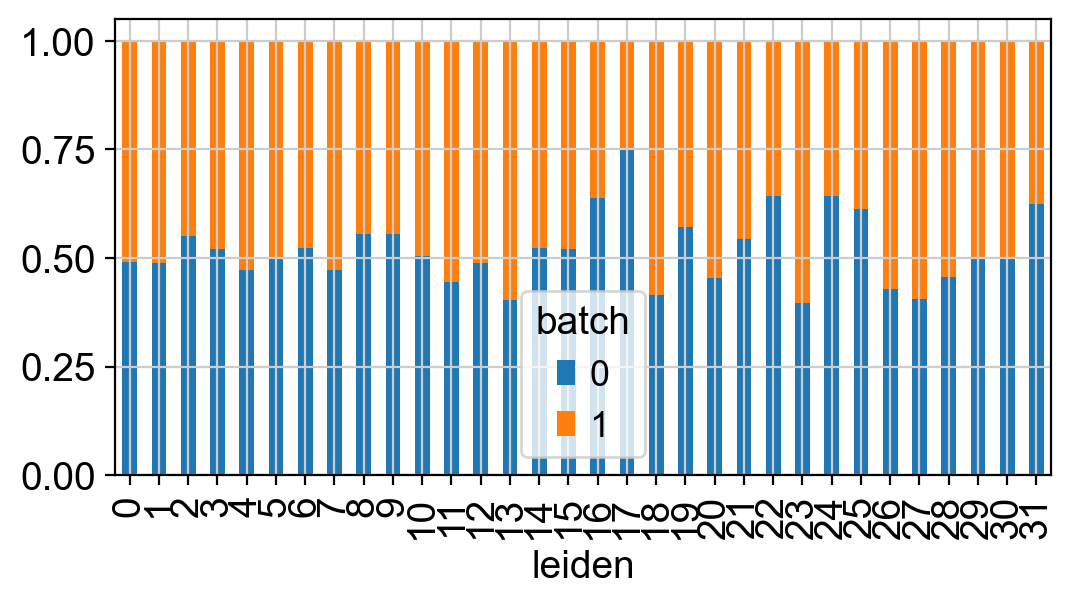

In [29]:
sc.pl.umap(adata_har, color=['batch', 'leiden'])
plot_batch_fr(adata_har)

# Harmony Z-score

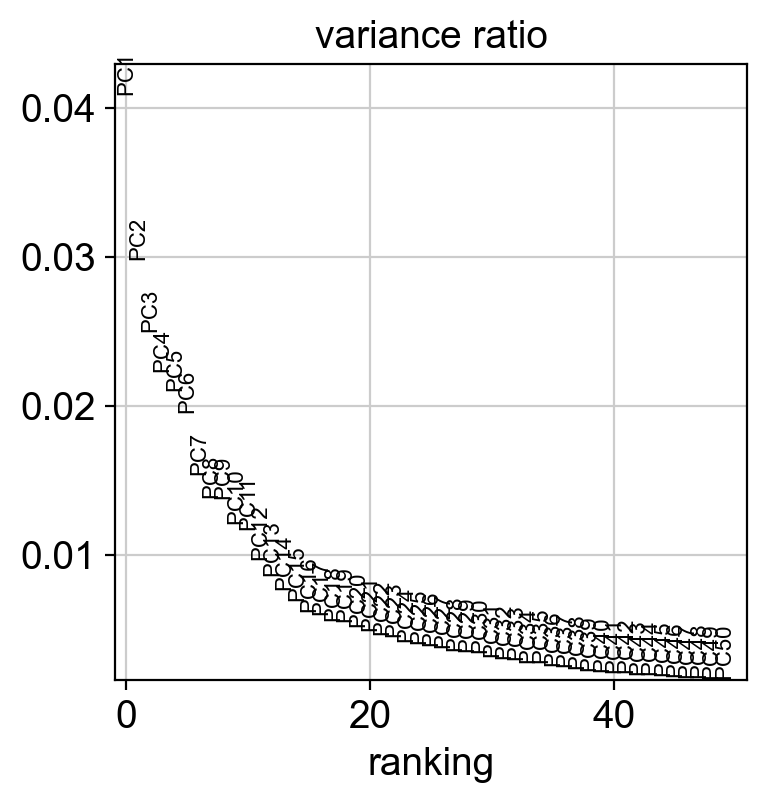

In [30]:
adata_har = adata.copy()
pr = False
adata_har = process_data(adata_har, pearson_residuals = pr, batch_key='batch', hv_subset = False)
adata_har = do_pca(adata_har, pearson_residuals = pr, n_comps =50)

In [31]:
# Run Harmony to correct PCA
sc.external.pp.harmony_integrate(adata_har, key='batch', max_iter_harmony=20)

# Calculate kNN graph
sc.pp.neighbors(adata_har, n_pcs=40, use_rep='X_pca_harmony')
# Calculate leiden clusters
sc.tl.leiden(adata_har)
# Calculate UMAP
sc.tl.umap(adata_har)

2024-05-13 22:44:40,819 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-13 22:44:42,426 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-13 22:44:42,505 - harmonypy - INFO - Iteration 1 of 20
2024-05-13 22:44:44,871 - harmonypy - INFO - Iteration 2 of 20
2024-05-13 22:44:47,398 - harmonypy - INFO - Iteration 3 of 20
2024-05-13 22:44:49,687 - harmonypy - INFO - Iteration 4 of 20
2024-05-13 22:44:50,671 - harmonypy - INFO - Iteration 5 of 20
2024-05-13 22:44:51,607 - harmonypy - INFO - Iteration 6 of 20
2024-05-13 22:44:52,448 - harmonypy - INFO - Iteration 7 of 20
2024-05-13 22:44:53,282 - harmonypy - INFO - Converged after 7 iterations


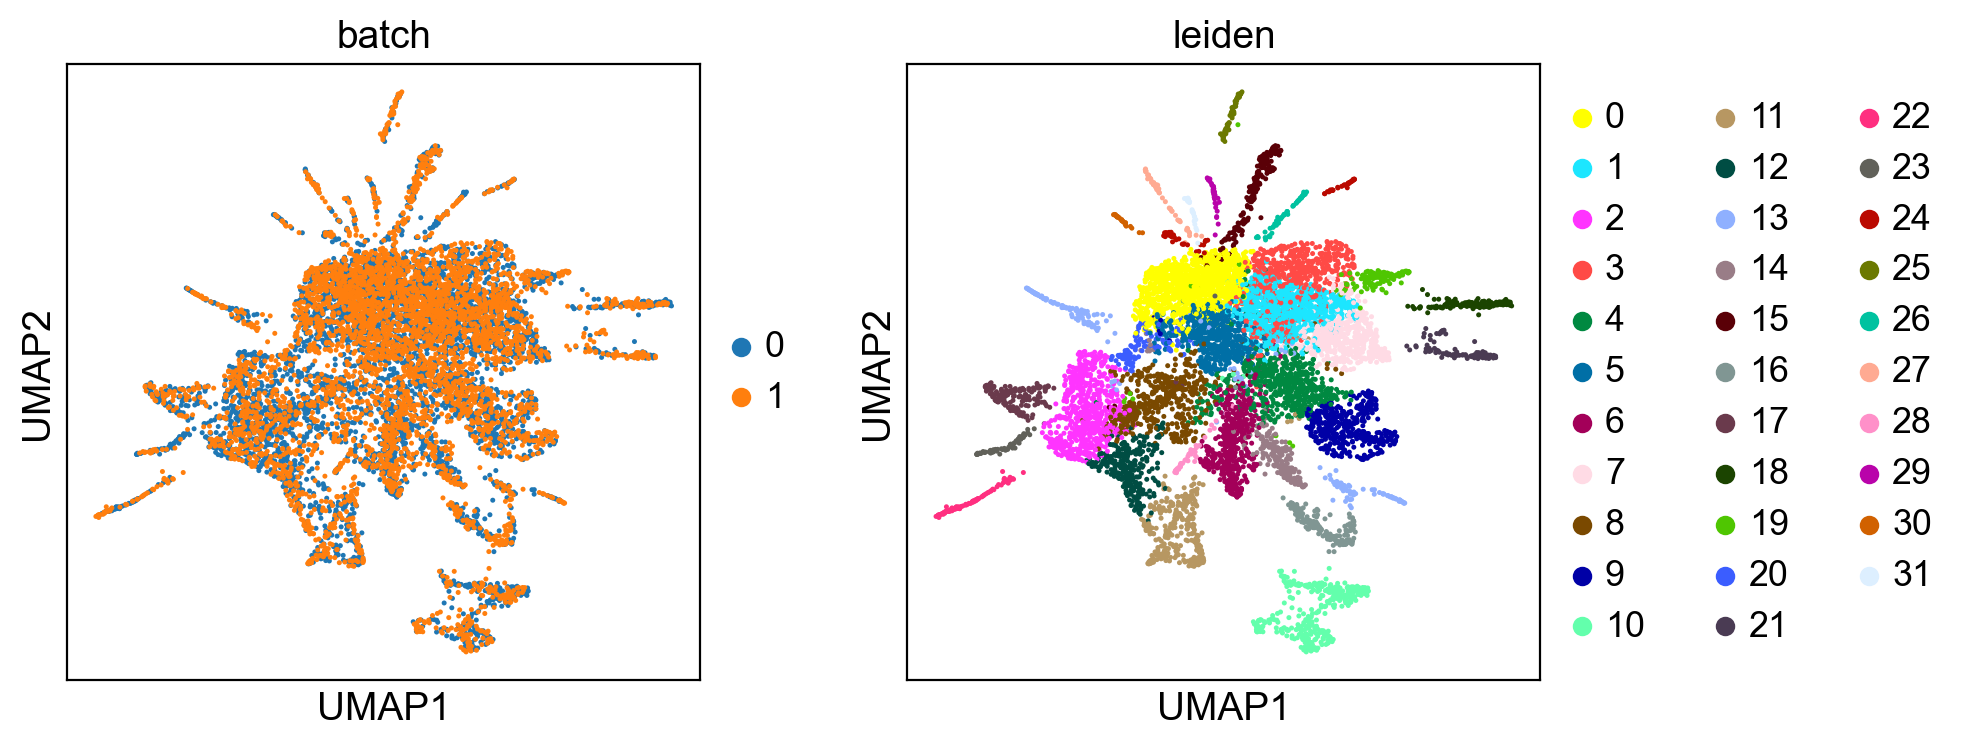

C:\Users\svk\AppData\Local\Temp\ipykernel_14112\4246019723.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_sum = adata.obs[['leiden', 'batch']]\


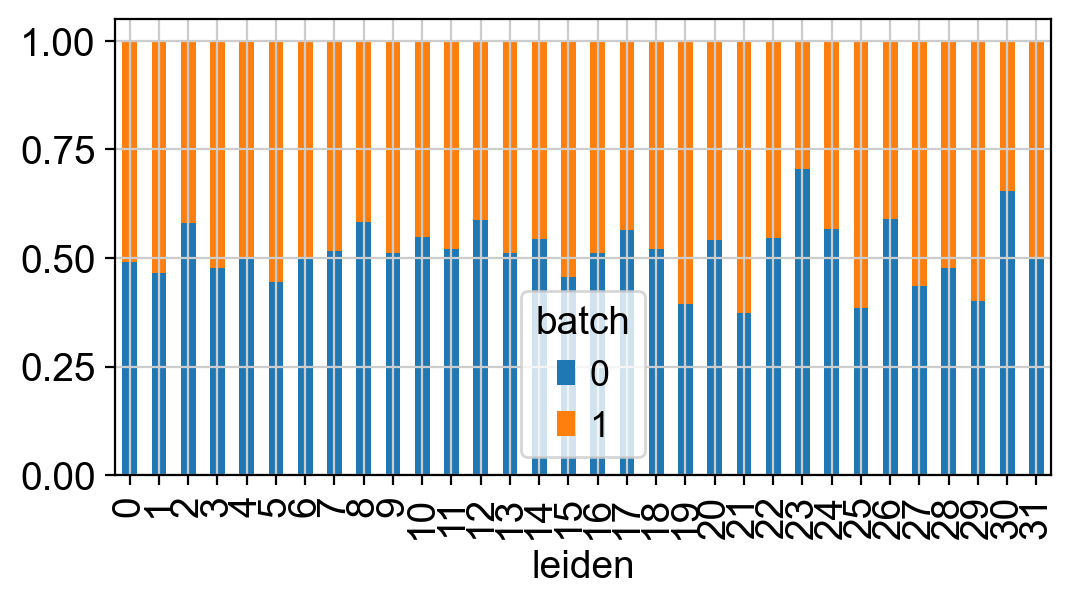

In [32]:
sc.pl.umap(adata_har, color=['batch', 'leiden'])
plot_batch_fr(adata_har)